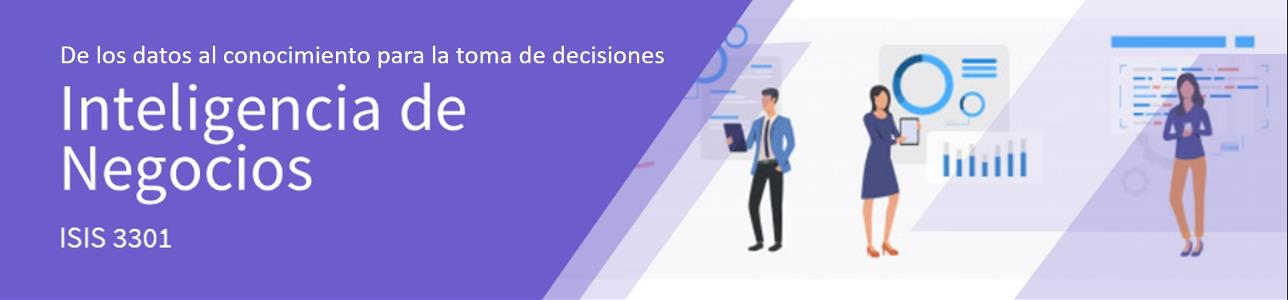

## Problema
El Ministerio de Comercio, Industria y Turismo de Colombia, la Asociación Hotelera y Turística de Colombia – COTELCO, cadenas hoteleras de la talla de Hilton, Hoteles Estelar, Holiday Inn y hoteles pequeños ubicados en diferentes municipios de Colombia están interesados en analizar las características de sitios turísticos que los hacen atractivos para
turistas locales o de otros países, ya sea para ir a conocerlos o recomendarlos. De igual manera, quieren comparar las características de dichos sitios, con aquellos que han obtenido bajas recomendaciones y que están afectando el número de turistas que llegan a ellos. Adicionalmente, quieren tener un mecanismo para determinar la calificación que tendrá un sitio por parte de los turistas y así, por ejemplo, aplicar estrategias para identificar oportunidades de mejora que permitan aumentar la popularidad de los sitios y fomentar el turismo.

Esos actores de turismo prepararon dos conjuntos de datos con reseñas de sitios turísticos. Cada reseña tiene una calificación según el sentimiento que tuvo el turista al visitarlo. Estos actores quieren lograr un análisis independiente de los conjuntos de datos y al final del proyecto discutir sobre los grupos de científicos de datos e ingenieros de datos que acompañarán el desarrollo real de este proyecto.

## 1. Instalación e importanción de librerías.


In [29]:
# librería Natural Language Toolkit, usada para trabajar con textos
!pip install ydata-profiling
!pip install contractions
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [30]:
# Instalación de librerias
import pandas as pd
import numpy as np

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

from wordcloud import STOPWORDS

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt

## 2. Perfilamiento y entendimiento de los datos



### 2.1. Lectura de los datos

In [31]:
data=pd.read_csv("https://raw.githubusercontent.com/Laudarias/BI-Proyecto1-GProy22/main/tipo2_entrenamiento_estudiantes.csv")
data.head()

,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


### 2.2. Entendimiento de los Datos

In [33]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Preparación de datos

### 3.1. Limpieza de los datos

El reporte nos indica que existen filas repetidas, podemos eliminarlas.

In [34]:
data = data.drop_duplicates(subset=['Review'])
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Al estar lidiando con textos, las palabras que más aparecerán son netamente gramaticales, como conjunciones y artículos, para el caso del español. Para eliminar dicho ruido, se usa la librería de stopwords para limpiar la data y tener resultados más significativos. Adicionalmente, para eliminar el ruido, se puede eliminar la puntuación, mayúsculas, acentos y en general todo caracter que no ASCII. Finalmente, podemos convertir todo número a su representación en letras, con esto nos aseguramos de que todos los datos son caracteres validos de ASCII, reduciendo así el ruido.

In [35]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words, stopwords=stopwords.words('spanish')):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 3.2. Normalización

Agregamos normalización para eliminar sufijos, prefijos y lematizar verbos a sus raíces.

In [36]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

### 3.3. Tokenización

Adicionalmente a la limpieza, resulta útil tokenizar los datos, esto nos permite luego separar frases completas.

In [37]:
review_t = data["Review"].apply(word_tokenize)

review_t = review_t.apply(preproccesing)

data["ReviewT"] = review_t.apply(stem_and_lemmatize)

<ipython-input-37-1d873734d2b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ReviewT"] = review_t.apply(stem_and_lemmatize)


In [38]:
data['ReviewT'] = data['ReviewT'].apply(lambda x: ' '.join(map(str, x)))

<ipython-input-38-25cb5220f1fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ReviewT'] = data['ReviewT'].apply(lambda x: ' '.join(map(str, x)))


## 4. Modelado


In [39]:
class TextPreprocessing(BaseEstimator,TransformerMixin):
    def __init__(self,stopwords=stopwords.words('spanish')):
        self.stopwords = stopwords

    def remove_non_ascii(self, words):
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words

    def to_lowercase(self, words):
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words

    def remove_punctuation(self, words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    def replace_numbers(self, words):
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words

    def remove_stopwords(self, words):
        new_words = []
        for word in words:
            if word not in self.stopwords:
                new_words.append(word)
        return new_words

    def stem_words(self, words):
        stemmer = SnowballStemmer('spanish')
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems

    def lemmatize_verbs(self, words):
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas

    def stem_and_lemmatize(self, words):
        words = self.stem_words(words)
        words = self.lemmatize_verbs(words)
        return words

    def preproccesing(self, words):
        words = self.to_lowercase(words)
        words = self.replace_numbers(words)
        words = self.remove_punctuation(words)
        words = self.remove_non_ascii(words)
        words = self.remove_stopwords(words)
        return words

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        X_train = pd.Series(X)
        X_train = X_train.apply(contractions.fix)
        X_train = X_train.apply(word_tokenize)
        X_train = X_train.apply(lambda x: self.preproccesing(x))
        X_train = X_train.apply(lambda x: self.stem_and_lemmatize(x))
        X_train = X_train.apply(lambda x: ' '.join(map(str, x)))
        return X_train

Separamos los datos limpios para probar y entrenar.

In [40]:
clean_data = data.copy()
clean_data = clean_data.drop(columns=['Review'])

In [41]:
train, test = train_test_split(clean_data, test_size=0.2, random_state=33)
train.head()

,Class,ReviewT
7498,4,segund ocasion aloj hotel motiv histori guard ...
1588,4,visit castill san felip baraj conoc mas increi...
736,5,si encant sushi restaur mas simplement mas sal...
705,5,much cos ver enorm tanqu tiburon 2 4 anos edad...
6793,2,pesim servici tard mas 20 minut orden alimemt ...


In [42]:
X_train, y_train = train['ReviewT'], train['Class']
display(X_train)
y_train

7498    segund ocasion aloj hotel motiv histori guard ...
1588    visit castill san felip baraj conoc mas increi...
736     si encant sushi restaur mas simplement mas sal...
705     much cos ver enorm tanqu tiburon 2 4 anos edad...
6793    pesim servici tard mas 20 minut orden alimemt ...
                              ...                        
2718    excelent opcion pued disfrut barri antigu tras...
578     antigu hotel glamour dud revolucion renov incr...
5898    hotel estand caden habit limpi personal atent ...
2450    resum histor mejor ubic servici horribl client...
7258    ubic hotel excelent cerc centr mty aparient pu...
Name: ReviewT, Length: 6241, dtype: object

7498    4
1588    4
736     5
705     5
6793    2
       ..
2718    4
578     2
5898    4
2450    1
7258    4
Name: Class, Length: 6241, dtype: int64

### 4.1. Modelo SVM

In [43]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('classifier', SVC(kernel='linear', probability=True))
    ]

pipe_SVM = Pipeline(estimators)

pipe_SVM.fit(X_train, y_train)

CPU times: user 1min 40s, sys: 130 ms, total: 1min 40s
Wall time: 1min 43s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('classifier', SVC(kernel='linear', probability=True))])

In [44]:
y_pred_train_SVM = pipe_SVM.predict(X_train)
y_pred_train_SVM

array([4, 4, 5, ..., 4, 1, 4])

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,size=(10,10)):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


<Axes: title={'center': 'Matriz de Confusión'}, xlabel='Predicted label', ylabel='True label'>

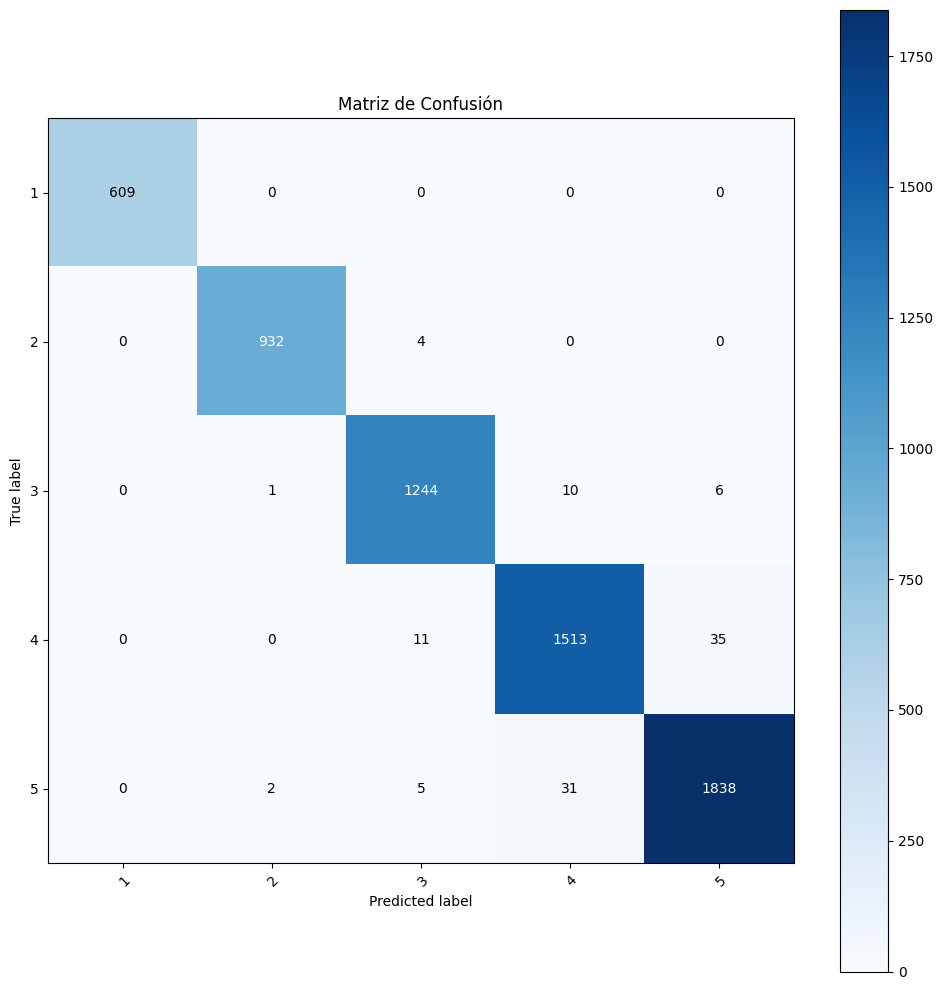

In [46]:
%matplotlib inline

classes = pipe_SVM['classifier'].classes_

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_SVM, classes=classes,
                      title='Matriz de Confusión')

In [47]:
report_SVC = classification_report(y_train, y_pred_train_SVM)

print("Reporte de Entrenamiento para Support Vector Machines\n", report_SVC)

Reporte de Entrenamiento para Support Vector Machines
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       609
           2       1.00      1.00      1.00       936
           3       0.98      0.99      0.99      1261
           4       0.97      0.97      0.97      1559
           5       0.98      0.98      0.98      1876

    accuracy                           0.98      6241
   macro avg       0.99      0.99      0.99      6241
weighted avg       0.98      0.98      0.98      6241



In [48]:
precision = accuracy_score(y_train, y_pred_train_SVM)

print("Precisión del modelo:", precision)

Precisión del modelo: 0.9831757731132831


### 4.2. Modelo Naive Bayes

In [49]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('classifier', MultinomialNB())
    ]

pipe_NB = Pipeline(estimators)

pipe_NB.fit(X_train, y_train)

CPU times: user 12.4 s, sys: 45.1 ms, total: 12.5 s
Wall time: 13.7 s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('classifier', MultinomialNB())])

In [50]:
y_pred_train_NB = pipe_NB.predict(X_train)
y_pred_train_NB

array([3, 5, 5, ..., 4, 1, 4])

Confusion matrix, without normalization


<Axes: title={'center': 'Matriz de Confusión'}, xlabel='Predicted label', ylabel='True label'>

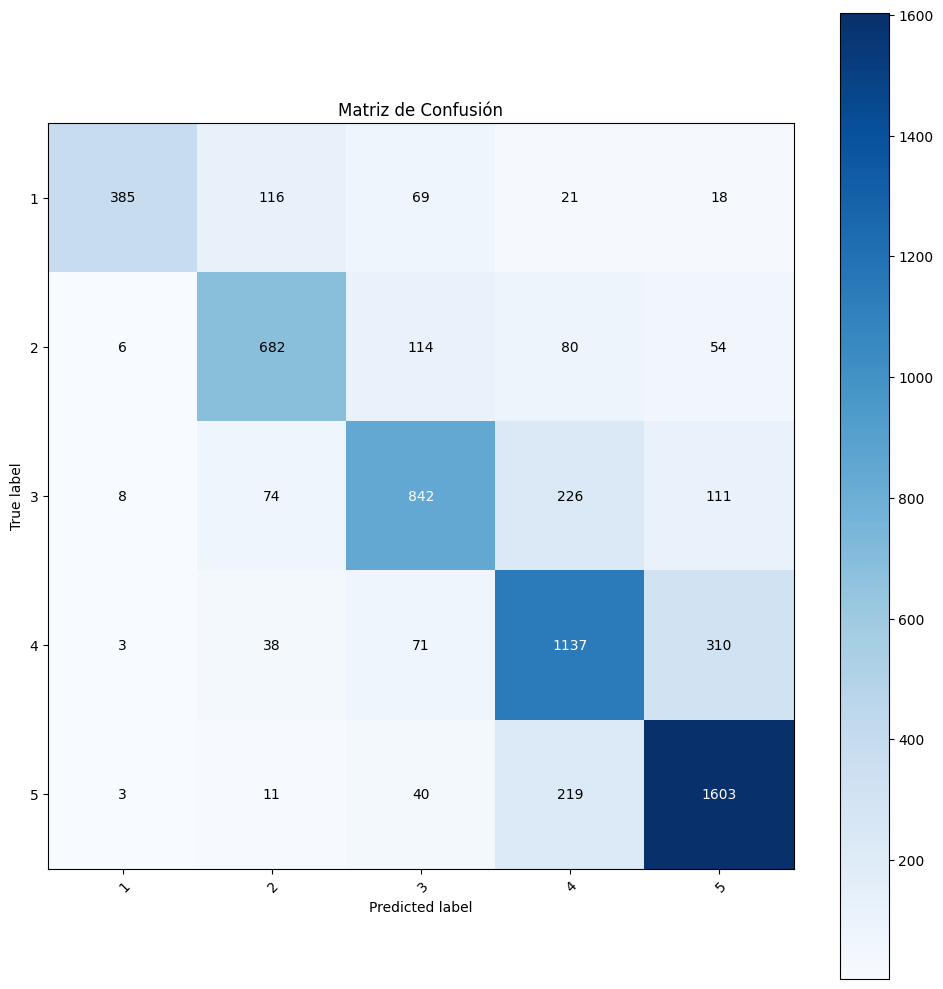

In [51]:
%matplotlib inline

classes = pipe_NB['classifier'].classes_

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_NB, classes=classes,
                      title='Matriz de Confusión')

In [52]:
report_NB = classification_report(y_train, y_pred_train_NB)

print("Reporte de Entrenamiento para Naive Bayes\n", report_NB)

Reporte de Entrenamiento para Naive Bayes
               precision    recall  f1-score   support

           1       0.95      0.63      0.76       609
           2       0.74      0.73      0.73       936
           3       0.74      0.67      0.70      1261
           4       0.68      0.73      0.70      1559
           5       0.76      0.85      0.81      1876

    accuracy                           0.74      6241
   macro avg       0.77      0.72      0.74      6241
weighted avg       0.75      0.74      0.74      6241



In [53]:
precision = accuracy_score(y_train, y_pred_train_NB)

print("Precisión del modelo:", precision)

Precisión del modelo: 0.7449126742509213


### 4.3. Modelo Random Forest

In [54]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('classifier', RandomForestRegressor())
    ]

pipe_RF = Pipeline(estimators)

pipe_RF.fit(X_train, y_train)

CPU times: user 2min 46s, sys: 195 ms, total: 2min 46s
Wall time: 2min 49s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('classifier', RandomForestRegressor())])

In [55]:
y_pred_train_RF = pipe_RF.predict(X_train)
y_pred_train_RF

array([3.65, 4.24, 4.6 , ..., 3.98, 1.61, 4.21])

In [56]:
mse_train_RF = mean_squared_error(y_train, y_pred_train_RF)

mae_train_RF = mean_absolute_error(y_train, y_pred_train_RF)

r2_train_RF = r2_score(y_train, y_pred_train_RF)

print("Métricas de rendimiento en el conjunto de entrenamiento:")
print("Error cuadrático medio - Mean Squared Error (MSE):", mse_train_RF)
print("Error absoluto medio - Mean Absolute Error (MAE):", mae_train_RF)
print("R cuadrado - R-squared (R^2):", r2_train_RF)

Métricas de rendimiento en el conjunto de entrenamiento:
Error cuadrático medio - Mean Squared Error (MSE): 0.12973781445281204
Error absoluto medio - Mean Absolute Error (MAE): 0.27849863803877584
R cuadrado - R-squared (R^2): 0.9252914771449623
